In [237]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.display.max_columns = 400

### Preset Lists (and Game Data)

In [238]:
game_data = nfl.import_schedules(years=range(2012,2023))

basic_cols = ['off_pass_epa',
 'off_pass_cpoe',
 'off_pass_success',
 'def_pass_epa',
 'def_pass_cpoe',
 'def_pass_success',
 'off_rush_epa',
 'off_rush_success',
 'def_rush_epa',
 'def_rush_success',
 'off_pepaw',
 'def_pepaw',
 'off_pass_rate',
 'def_pass_rate',
 'off_boom',
 'off_bust',
 'off_bob',
 'def_boom',
 'def_bust',
 'def_bob']

cols_to_drop = ['off_pass_epa',
       'off_pass_cpoe', 'off_pass_success', 'def_pass_epa',
       'def_pass_cpoe', 'def_pass_success', 'off_rush_epa',
       'off_rush_success', 'def_rush_epa', 'def_rush_success',
       'off_pepaw', 'def_pepaw', 'off_boom', 'def_boom', 'off_bust',
       'def_bust', 'off_bob', 'def_bob', 'off_pass_rate', 'def_pass_rate',
       'off_pass_epa_over_opp_trend', 'off_rush_epa_over_opp_trend',
       'def_pass_epa_over_opp_trend', 'def_rush_epa_over_opp_trend',
       'off_pass_success_over_opp_trend',
       'off_rush_success_over_opp_trend',
       'def_pass_success_over_opp_trend',
       'def_rush_success_over_opp_trend', 'off_pass_cpoe_over_opp_trend',
       'def_pass_cpoe_over_opp_trend', 'off_pepaw_over_opp_trend',
       'def_pepaw_over_opp_trend','mov']

trends = []

### Functions

In [239]:
def build_basic(first_season,last_season):
    years = range(first_season,last_season+1)
    game_data = nfl.import_schedules(years=years)
    game_data.loc[(game_data['home_team']=='OAK'),'home_team'] = 'LV'
    game_data.loc[(game_data['home_team']=='STL'),'home_team'] = 'LA'
    game_data.loc[(game_data['home_team']=='SD'),'home_team'] = 'LAC'
    
    df = nfl.import_pbp_data(years, downcast=True, cache=False, alt_path=None)

    df['gt'] = False #Create GT column
    df.loc[(df['home_wp'] >= .87) | (df['home_wp'] <= .13),'gt'] = True #Set GT scenarios to true
    df.loc[(df['gt']==True),'epa'] *= .5 #Downweight EPA in near-GT (when one team has between 6%-13% WP)

    df = df.loc[(df['home_wp'].between(.05,.95,inclusive='both'))] #Remove all plays where a team has a 5% or less WP

    df['pepaw'] = df['epa']
    df.loc[(df['rush'] == 1),'pepaw'] = df['epa'] * (1-df['xpass']) #PEPAW, downweight based on play expectation
    df.loc[(df['pass'] == 1),'pepaw'] = df['epa'] * df['xpass']

    df['pass_boom'] = 0 #At or above 90th percentile of passing EPA (1.94)
    df['pass_bust'] = 0 #At or below 10th percentile of passing EPA (-1.45)
    df.loc[(df['pass']==1) & (df['epa']>= 1.94),'pass_boom'] = 1
    df.loc[(df['pass']==1) & (df['epa']<= -1.45),'pass_bust'] = 1


    df['rush_boom'] = 0 #At or above 90th percentile of rushing EPA (.94)
    df['rush_bust'] = 0 #At or below 10th percentile of rushing EPA (-.95)
    df.loc[(df['rush']==1) & (df['epa']>= .94),'rush_boom'] = 1
    df.loc[(df['rush']==1) & (df['epa']<= -.95),'rush_bust'] = 1


    df['pepaw_boom'] = 0 #At or above 90th percentile of PEPAW (.94)
    df['pepaw_bust'] = 0 #At or below 10th percentile of PEPAW (-.84)
    df.loc[(df['pepaw']>=.94),'pepaw_boom'] = 1
    df.loc[(df['pepaw']<=-.84),'pepaw_bust'] = 1


    df_rush_off = df.loc[df['rush']==1].groupby(['game_id','posteam','season','week'],as_index = False).agg(off_rush_epa=('epa',np.mean), #Group plays by game to find average/total rush stats
                                                                                                    off_rush_success=('success',np.mean),
                                                                                                    off_rush_boom=('rush_boom',np.sum),
                                                                                                    off_rush_bust=('rush_bust',np.sum),
                                                                                                    off_rush_plays=('play_id',np.count_nonzero))

    df_rush_def = df.loc[df['rush']==1].groupby(['game_id','defteam','season','week'],as_index = False).agg(def_rush_epa=('epa',np.mean),
                                                                                                    def_rush_success=('success',np.mean),
                                                                                                    def_rush_boom=('rush_boom',np.sum),
                                                                                                    def_rush_bust=('rush_bust',np.sum),
                                                                                                    def_rush_plays=('play_id',np.count_nonzero))

    df_rush_def['def_rush_boom_temp'] = df_rush_def['def_rush_boom'] #Fancy-pants value swapping to set the offensive boom = defensive bust, etc.
    df_rush_def['def_rush_boom'] = df_rush_def['def_rush_bust']
    df_rush_def['def_rush_bust'] = df_rush_def['def_rush_boom_temp']
    df_rush_def = df_rush_def.drop(columns=['def_rush_boom_temp'])

    df_rush_off = df_rush_off.rename(columns={'posteam':'team'})                                                                                                
    df_rush_def = df_rush_def.rename(columns={'defteam':'team'})

    df_rush = pd.merge(df_rush_off,df_rush_def,on=['game_id','team','season','week']) #Combine off/def

    df_pass_off = df.loc[df['pass']==1].groupby(['game_id','posteam','season','week'],as_index = False).agg(off_pass_epa=('epa',np.mean), #Group plays by game to find average/total pass stats
                                                                                                    off_pass_cpoe=('cpoe',np.mean),
                                                                                                    off_pass_success=('success',np.mean),
                                                                                                    off_pass_boom=('pass_boom',np.sum),
                                                                                                    off_pass_bust=('pass_bust',np.sum),
                                                                                                    off_pass_plays=('play_id',np.count_nonzero))

    df_pass_def = df.loc[df['pass']==1].groupby(['game_id','defteam','season','week'],as_index = False).agg(def_pass_epa=('epa',np.mean),
                                                                                                    def_pass_cpoe=('cpoe',np.mean),
                                                                                                    def_pass_success=('success',np.mean),
                                                                                                    def_pass_boom=('pass_boom',np.sum),
                                                                                                    def_pass_bust=('pass_bust',np.sum),
                                                                                                    def_pass_plays=('play_id',np.count_nonzero))

    df_pass_def['def_pass_boom_temp'] = df_pass_def['def_pass_boom'] #Value swapping
    df_pass_def['def_pass_boom'] = df_pass_def['def_pass_bust']
    df_pass_def['def_pass_bust'] = df_pass_def['def_pass_boom_temp']
    df_pass_def = df_pass_def.drop(columns=['def_pass_boom_temp'])


    df_pass_off = df_pass_off.rename(columns={'posteam':'team'})                                                                             
    df_pass_def = df_pass_def.rename(columns={'defteam':'team'})

    df_pass = pd.merge(df_pass_off,df_pass_def,on=['game_id','team','season','week']) #Combine

    df_basic = pd.merge(df_pass,df_rush,on=['game_id','team','season','week']) #Combine
    df_pepaw_off = df.groupby(['game_id','posteam','season','week'],as_index=False).agg(off_pepaw=('pepaw',np.mean)) #Pepaw averages
    df_pepaw_def = df.groupby(['game_id','defteam','season','week'],as_index=False).agg(def_pepaw=('pepaw',np.mean))
    df_pepaw_off = df_pepaw_off.rename(columns={'posteam':'team'})
    df_pepaw_def = df_pepaw_def.rename(columns={'defteam':'team'})
    df_basic = pd.merge(df_basic,df_pepaw_off[['game_id','team','season','week','off_pepaw']],on=['game_id','team','season','week'])
    df_basic = pd.merge(df_basic,df_pepaw_def[['game_id','team','season','week','def_pepaw']],on=['game_id','team','season','week'])

    df_basic['off_boom'] = (df_basic['off_pass_boom'] + df_basic['off_rush_boom'])/(df_basic['off_pass_plays'] + df_basic['off_rush_plays']) #BOBs
    df_basic['def_boom'] = (df_basic['def_pass_boom'] + df_basic['def_rush_boom'])/(df_basic['def_pass_plays'] + df_basic['def_rush_plays'])
    df_basic['off_bust'] = (df_basic['off_pass_bust'] + df_basic['off_rush_bust'])/(df_basic['off_pass_plays'] + df_basic['off_rush_plays'])
    df_basic['def_bust'] = (df_basic['def_pass_bust'] + df_basic['def_rush_bust'])/(df_basic['def_pass_plays'] + df_basic['def_rush_plays'])

    df_basic['off_bob'] = (df_basic['off_pass_boom'] + df_basic['off_pass_bust'] + df_basic['off_rush_boom'] + df_basic['off_rush_bust'])/(df_basic['off_pass_plays'] + df_basic['off_rush_plays'])
    df_basic['def_bob'] = (df_basic['def_pass_boom'] + df_basic['def_pass_bust'] + df_basic['def_rush_boom'] + df_basic['def_rush_bust'])/(df_basic['def_pass_plays'] + df_basic['def_rush_plays'])

    df_basic['off_pass_rate'] = df_basic['off_pass_plays'] / (df_basic['off_pass_plays'] + df_basic['off_rush_plays']) #Pass rate
    df_basic['def_pass_rate'] = df_basic['def_pass_plays'] / (df_basic['def_pass_plays'] + df_basic['def_rush_plays'])

    return(game_data,df_basic)

def dynamic_window_ewma(df, cols):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    df_to_return = df.sort_values(['team','season','week']).copy()
    df_to_return =df_to_return.reset_index(drop=True)
    for t in df_to_return.team.unique():
        for x in df_to_return[df_to_return['team']==t].index:
            for i in cols:
                if df_to_return.at[x,'week'].item() > 10:
                    df_to_return[i + '_ewma'] = df_to_return[i].ewm(min_periods=1,span=df.at[x,'week'].item()).mean().shift(1)
                else:
                    df_to_return[i + '_ewma'] = df_to_return[i].ewm(min_periods=1,span=10).mean().shift(1)

    return df_to_return


def build_ewma_opponents_trends(df,game_data):
    df_ewma = df.copy().drop(columns=['off_rush_plays','def_rush_plays','off_pass_plays','def_pass_plays','off_pass_boom','off_pass_bust','def_pass_boom','def_pass_bust','off_rush_boom','off_rush_bust','def_rush_boom','def_rush_bust']) #Get rid of single game totals
    df_ewma = dynamic_window_ewma(df_ewma,basic_cols) #Apply ewma function
    
    df_opps = df_ewma.copy().merge(game_data[['game_id','home_team','away_team']],on=['game_id']) #Create opponent info (not stats)
    df_opps['opp'] = df_opps['away_team']
    df_opps.loc[(df_opps['team']==df_opps['away_team']),'opp'] = df_opps['home_team'] #Conditionally set opponent

    df_ewma = df_ewma.merge(df_opps[['game_id','team','opp']],on=['game_id','team']) #Add opponent column to ewma df so we can merge opponents data in
    ewma_cols = [col for col in df_ewma if 'ewma' in col or 'game_id' in col or 'team' in col]
    df_dummy_flipped = df_ewma.copy() #Just placeholder df
    df_with_opp_data = pd.merge(df_ewma,df_dummy_flipped[ewma_cols],left_on=['game_id','opp'],right_on=['game_id','team'],suffixes=('','_opp')) #Merge opponents pbp data onto teams own data
    df_with_opp_data = df_with_opp_data.drop(columns=['opp','team_opp'])
    df_with_opp_data

    clean_df = df_with_opp_data.dropna(subset=['off_pass_epa_ewma']) #Get rid of first rows (NA because of the shift)
    clean_df['off_pass_epa_over_opp_trend'] = clean_df['off_pass_epa'] - clean_df['def_pass_epa_ewma_opp'] #Compare how team A performed in a specific game relative to the trend value (EWMA) of Team B's opposite group (off pass v def pass, off rush v def rush)
    clean_df['off_rush_epa_over_opp_trend'] = clean_df['off_rush_epa'] - clean_df['def_rush_epa_ewma_opp']
    clean_df['def_pass_epa_over_opp_trend'] = clean_df['def_pass_epa'] - clean_df['off_pass_epa_ewma_opp']
    clean_df['def_rush_epa_over_opp_trend'] = clean_df['def_rush_epa'] - clean_df['off_rush_epa_ewma_opp']

    clean_df['off_pass_success_over_opp_trend'] = clean_df['off_pass_success'] - clean_df['def_pass_success_ewma_opp'] #More
    clean_df['off_rush_success_over_opp_trend'] = clean_df['off_rush_success'] - clean_df['def_rush_success_ewma_opp']
    clean_df['def_pass_success_over_opp_trend'] = clean_df['def_pass_success'] - clean_df['off_pass_success_ewma_opp']
    clean_df['def_rush_success_over_opp_trend'] = clean_df['def_rush_success'] - clean_df['off_rush_success_ewma_opp']

    clean_df['off_pass_cpoe_over_opp_trend'] = clean_df['off_pass_cpoe'] - clean_df['def_pass_cpoe_ewma_opp'] #More
    clean_df['def_pass_cpoe_over_opp_trend'] = clean_df['def_pass_cpoe'] - clean_df['off_pass_cpoe_ewma_opp']

    clean_df['off_pepaw_over_opp_trend'] = clean_df['off_pepaw'] - clean_df['def_pepaw_ewma_opp'] #More
    clean_df['def_pepaw_over_opp_trend'] = clean_df['def_pepaw'] - clean_df['off_pepaw_ewma_opp']

    trends = [col for col in clean_df.columns if 'trend' in col]

    df_return = dynamic_window_ewma(clean_df,trends) #Now find Trend (EWMA) of Team A's performance relative to Team B's trends

    return(df_return)
    
def add_game_info(df,game_data):
    stats = df.copy()
    stats = pd.merge(stats,game_data[['game_id','home_team','location','home_score','away_score','result','total','home_rest','away_rest','div_game','roof','spread_line','total_line','game_type']],on='game_id') #Add game data

    stats['is_home'] = 0 #Set home flags
    stats.loc[(stats['home_team'] == stats['team']) & (stats['location']=='Home'),'is_home'] = 1
    #drop
    # stats = stats.drop(columns=['location'])

    stats['is_playoff'] = 1 #Playoff flag
    stats.loc[stats['game_type']== 'REG','is_playoff'] = 0
    #drop
    stats['is_neutral'] = 0 #Neutral flag
    stats.loc[stats['location']== 'Neutral','is_neutral'] = 1

    stats['mov'] = stats['result'] #not only one fixed value now. Reflects the specified teams margin
    stats.loc[stats['is_home']==0,'mov'] = stats['result'] * -1

    stats['win'] = 0 #Win flag
    stats.loc[stats['mov'] > 0,'win'] = 1

    stats['exp_mov'] = stats['spread_line'] #Same concept as mov but vegas line now
    stats.loc[stats['is_home'] == 0,'exp_mov'] = stats['spread_line'] * -1
    stats['rest_diff'] = stats['home_rest'] - stats['away_rest'] #Home team has X many more days of rest than away team
    stats.loc[stats['is_home']==0,'rest_diff'] = stats['away_rest'] - stats['home_rest']

    stats['vmov'] = stats['mov'] - stats['exp_mov'] #Margin against the spread. i.e. how much did you cover/fail to cover by

    stats = stats.drop(columns=['home_team','location','home_rest','game_type','away_rest','roof']) #Get dis junk outta here!

    stats = dynamic_window_ewma(stats,['exp_mov','vmov']) #Trend of team's performance relative to vegas expectations
    df_to_split = stats.drop(columns=cols_to_drop) #Drop bad columns that would give it away
    home_data = df_to_split.loc[(df_to_split['is_home']==True)] #Make home and away sets
    away_data = df_to_split.loc[(df_to_split['is_home']==False)]

    trends = [col for col in df_to_split.columns if 'trend' in col]
    trends.append('game_id')

    # home_data = home_data.merge(away_data[trends],on='game_id',suffixes=('','_opp'))
    # away_data = away_data.merge(home_data[trends],on='game_id',suffixes=('','_opp'))

    away_data = away_data[['game_id', 'team','off_pass_epa_ewma', #Get rid of redundencies (like game data ((week, season, etc)) we already have in home)
        'off_pass_cpoe_ewma', 'off_pass_success_ewma', 'def_pass_epa_ewma',
        'def_pass_cpoe_ewma', 'def_pass_success_ewma', 'off_rush_epa_ewma',
        'off_rush_success_ewma', 'def_rush_epa_ewma',
        'def_rush_success_ewma', 'off_pepaw_ewma', 'def_pepaw_ewma',
        'off_pass_rate_ewma', 'def_pass_rate_ewma', 'off_boom_ewma',
        'off_bust_ewma', 'off_bob_ewma', 'def_boom_ewma', 'def_bust_ewma',
        'def_bob_ewma', 'off_pass_epa_ewma_opp', 'off_pass_cpoe_ewma_opp',
        'off_pass_success_ewma_opp', 'def_pass_epa_ewma_opp',
        'def_pass_cpoe_ewma_opp', 'def_pass_success_ewma_opp',
        'off_rush_epa_ewma_opp', 'off_rush_success_ewma_opp',
        'def_rush_epa_ewma_opp', 'def_rush_success_ewma_opp',
        'off_pepaw_ewma_opp', 'def_pepaw_ewma_opp',
        'off_pass_rate_ewma_opp', 'def_pass_rate_ewma_opp',
        'off_boom_ewma_opp', 'off_bust_ewma_opp', 'off_bob_ewma_opp',
        'def_boom_ewma_opp', 'def_bust_ewma_opp', 'def_bob_ewma_opp',
        'off_pass_epa_over_opp_trend_ewma',
        'off_rush_epa_over_opp_trend_ewma',
        'def_pass_epa_over_opp_trend_ewma',
        'def_rush_epa_over_opp_trend_ewma',
        'off_pass_success_over_opp_trend_ewma',
        'off_rush_success_over_opp_trend_ewma',
        'def_pass_success_over_opp_trend_ewma',
        'def_rush_success_over_opp_trend_ewma',
        'off_pass_cpoe_over_opp_trend_ewma',
        'def_pass_cpoe_over_opp_trend_ewma',
        'off_pepaw_over_opp_trend_ewma', 'def_pepaw_over_opp_trend_ewma']]

    df_return = pd.merge(home_data,away_data,on=['game_id'],suffixes=('_home','_away')) #Merge and add suffixes
    df_return = df_return.drop(index = [df_return[df_return.isna().any(axis=1)].index.item()]) #Get rid of NANs
    df_return['cover'] = 0 
    df_return.loc[df_return['vmov']> 0, 'cover'] = 1
    
    return(df_return)


In [240]:
# game_data, df = build_basic(2012,2023)
# ewma_df = build_ewma_opponents_trends(df, game_data)
final_df = add_game_info(ewma_df,game_data)

In [211]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [241]:
training = final_df.loc[final_df['season'] < 2021]
# training.to_csv('train.csv')
testing = final_df.loc[final_df['season'] >= 2021]
# testing.to_csv('test.csv')

In [242]:
X_train = training.drop(columns=['team_home','team_away','win','total','game_id','season','vmov','week','home_score','away_score','total_line','spread_line','result','cover'])
X_test = testing.drop(columns=['team_home','team_away','win','total','game_id','season','vmov','week','home_score','away_score','total_line','spread_line','result','cover'])
y_train_reg = training['result']
y_test_reg = testing['result']
y_train_clf = training['cover']
y_test_clf = testing['cover']


### XGBoost Regressor

In [243]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(eval_metric='rmse')
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}
search = GridSearchCV(xgb_reg, param_grid,cv=5).fit(X_train,y_train_reg)

xgb_reg_gs = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"])
xgb_reg_gs.fit(X_train,y_train_reg)      

testing['pred_reg'] = xgb_reg_gs.predict(X_test)

C:\Users\willi\AppData\Local\Temp\ipykernel_6548\1664154410.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['pred_reg'] = xgb_reg_gs.predict(X_test)


In [244]:
from sklearn.metrics import mean_squared_error


mse = mean_squared_error(y_test_reg,testing['pred_reg'])

print(f'MSE: {mse}')

MSE: 180.04850539023633


### XGBoost Regressor

In [245]:
xgb_clf = xgb.XGBClassifier()
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

search_clf = GridSearchCV(xgb_clf, param_grid,cv=5).fit(X_train,y_train_clf)

xgb_clf_gs = xgb.XGBRegressor(learning_rate = search_clf.best_params_["learning_rate"],
                           n_estimators  = search_clf.best_params_["n_estimators"],
                           max_depth     = search_clf.best_params_["max_depth"])
xgb_clf_gs.fit(X_train,y_train_clf)     

testing['pred_clf'] = xgb_clf_gs.predict(X_test)

C:\Users\willi\AppData\Local\Temp\ipykernel_6548\1694619159.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['pred_clf'] = xgb_clf_gs.predict(X_test)


In [250]:
from sklearn.metrics import accuracy_score, mean_absolute_error


results = testing.copy()
results['true_mov'] = y_test_reg
results['pred_cover'] = 0
results.loc[(results['pred_clf']>=.5),'pred_cover'] = 1

acc21 = accuracy_score(results.loc[(results['season']==2021),'cover'],results.loc[(results['season']==2021),'pred_cover'])
acc22 = accuracy_score(results.loc[(results['season']==2022),'cover'],results.loc[(results['season']==2022),'pred_cover'])
print(f"2021 Accuracy: {acc21}")
print(f"2022 Accuracy: {acc22}")


2021 Accuracy: 0.5444839857651246
2022 Accuracy: 0.5416666666666666


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

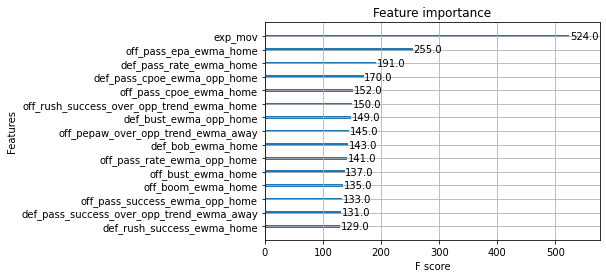

In [251]:
from xgboost import plot_importance

plot_importance(xgb_reg_gs,max_num_features=15)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

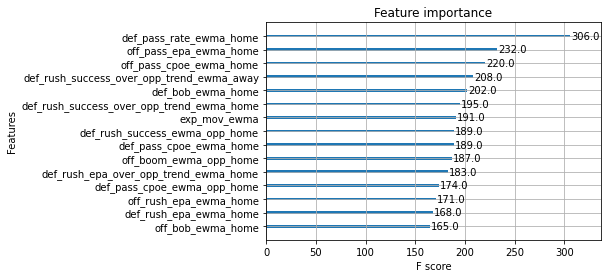

In [247]:


plot_importance(xgb_clf_gs,max_num_features=15)

In [248]:
results['push'] = 0
results.loc[(results['true_mov']==results['exp_mov']),'push'] = 1
results['home_cover_pred'] = False
results.loc[(results['home_cover_pred']>results['exp_mov']),'home_cover_pred'] = True
results['home_cover_true'] = False
results.loc[(results['true_mov']>results['exp_mov']),'home_cover_true'] = True
results['reg_win'] = 0
results.loc[(results['home_cover_pred'] == results['home_cover_true']),'reg_win'] = 1
results['reg_loss'] = 1 - results['reg_win']

results['clf_win'] = 0
results.loc[(results['pred_cover'] == results['home_cover_true']),'clf_win'] = 1
results['clf_loss'] = 1 - results['clf_win']

In [249]:
results.groupby(['season'],as_index=False).agg(reg_win=('reg_win',np.sum),
                                               reg_loss=('reg_loss',np.sum),
                                               push=('push',np.sum),
                                               clf_win=('clf_win',np.sum),
                                               clf_loss=('clf_loss',np.sum))

,season,reg_win,reg_loss,push,clf_win,clf_loss
0,2021,150,131,4,153,128
1,2022,65,55,3,65,55
